In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import re
import string
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

2023-06-28 14:24:47.621778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(42)

In [3]:
# import os
# os.environ['WANDB_MODE'] = 'offline'


### Load dataset

In [4]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
"Running in colab" if IN_COLAB else "Running locally"

'Running locally'

### Init wandb

In [5]:
if IN_COLAB:
  !pip install wandb -q
  !pip install python-dotenv -q
  !pip install ruamel.yaml -q

import wandb

from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)
from ruamel.yaml import YAML

In [6]:
import os
from dotenv import load_dotenv; load_dotenv("wandb.env")
os.environ["WANDB_NOTEBOOK_NAME"] = "translate_train.ipynb"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amirfvb. Use `wandb login --relogin` to force relogin


True

In [7]:
yaml=YAML(typ='safe')
with open('trans_params.yaml', 'r') as file:
    config_file = yaml.load(file)

wandb.init(
    # set the wandb project where this run will be logged
    project="CRNN_translate",

    # name="test_determinism",
    # notes="Removed gradient clipping",
    config=config_file,
    save_code=True,
)
# wandb.run.log_code(include_fn=lambda path: path.endswith("translate_train.ipynb"))
wandb.run.log_code(include_fn=lambda path: path.endswith(".ipynb") or path.endswith(".py"))
config = wandb.config

In [8]:
UNITS = config["hidden_dims"]
input_dim = config["input_size"]

### Dataset loading

In [9]:
if IN_COLAB:
    # download dataset

    import pathlib

    path_to_zip = tf.keras.utils.get_file(
        'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
        extract=True)

    path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

    def load_data(path):
        text = path.read_text(encoding='utf-8')

        lines = text.splitlines()
        pairs = [line.split('\t') for line in lines]

        context = np.array([context for target, context in pairs])
        target = np.array([target for target, context in pairs])

        return target, context

    target_raw, context_raw = load_data(path_to_file)

    print(context_raw[-1])
    print(target_raw[-1])

else:
    df = pd.read_csv("data/spa-eng.zip", delimiter="\t", names=["translate", "source", "attr"])
    context_raw = np.array(df["source"])
    target_raw = np.array(df["translate"])
    print(context_raw[-1])
    print(target_raw[-1])

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8 # todo. Check reproducibility and across methods (colab/not colab)


train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))



Un día, me desperté y vi que Dios me había puesto pelo en la cara. Me lo afeité. Al día siguiente, vi que Dios me lo había vuelto a poner en la cara, así que me lo afeité otra vez. Al tercer día, cuando vi que Dios me había puesto pelo en la cara de nuevo, decidí que Dios se saliera con la suya. Por eso tengo barba.
One day, I woke up to find that God had put hair on my face. I shaved it off. The next day, I found that God had put it back on my face, so I shaved it off again. On the third day, when I found that God had put hair back on my face again, I decided to let God have his way. That's why I have a beard.


#### My dataset processing

In [10]:
def custom_standardization(text):

  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text,
                                  '[%s]' % re.escape(string.punctuation + "¿¡"), '')
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text
vocab_size = 5000
# sequence_length = 250



context_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', 'de', 'que', 'no', 'tom', 'a', 'la']

In [11]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'i', 'the', 'to', 'you', 'tom', 'a']

#### End of text processings

In [12]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [13]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [14]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

### define model

In [15]:
%load_ext autoreload

%autoreload 2

In [16]:
if config["model"] == "attention_gru":
    from attention_gru_translate_model  import Translator
    # wandb.run.log_code(include_fn=lambda path: path.endswith("attention_gru_translate_model.py"))

    model_kwargs = {"attention": True}

elif config["model"] == "gru":

    from gru_translate_model  import Translator
    # wandb.run.log_code(include_fn=lambda path: path.endswith("attention_gru_translate_model.py"))

    model_kwargs = {}

elif config["model"] == "crnn":
    from context_rnn_translate_model import Translator
    # wandb.run.log_code(include_fn=lambda path: path.endswith("attention_gru_translate_model.py"))

    model_kwargs = {}
# elif config["model"] == "attention_crnn":
#     from context_rnn_translate_model import Translator
#     # wandb.run.log_code(include_fn=lambda path: path.endswith("attention_gru_translate_model.py"))

#     model_kwargs = {"attention": True}
else:
    raise NotImplementedError("Model " + config["model"] + " is not implemented")

In [17]:
model = Translator(UNITS, context_text_processor, target_text_processor, input_dim, **model_kwargs)

In [18]:
model.compile(optimizer=Adam(learning_rate=config["lr"]),
              loss=masked_loss,
              metrics=[masked_acc])

In [19]:
history = model.fit(
    train_ds,
    epochs=config["epochs"],
    # steps_per_epoch = 100,
    validation_data=val_ds,
    # validation_steps = 20,
    shuffle=False,
    callbacks=[
        # tf.keras.callbacks.EarlyStopping(patience=3),
        WandbMetricsLogger()])

Epoch 1/2
1747/1747 [==============================] - 76s 41ms/step - loss: 5.5007 - masked_acc: 0.1662 - val_loss: 5.5811 - val_masked_acc: 0.0475
Epoch 2/2
1747/1747 [==============================] - 69s 39ms/step - loss: 4.7869 - masked_acc: 0.2184 - val_loss: 5.6645 - val_masked_acc: 0.0985


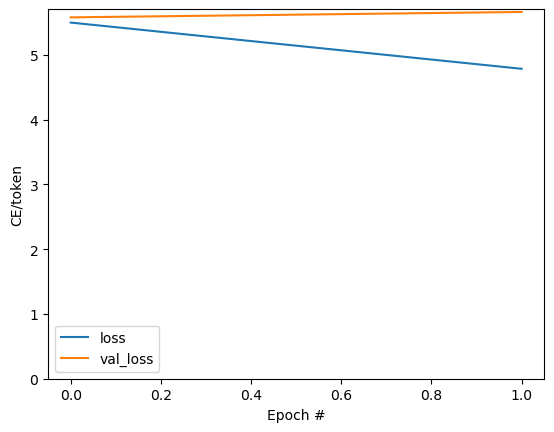

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

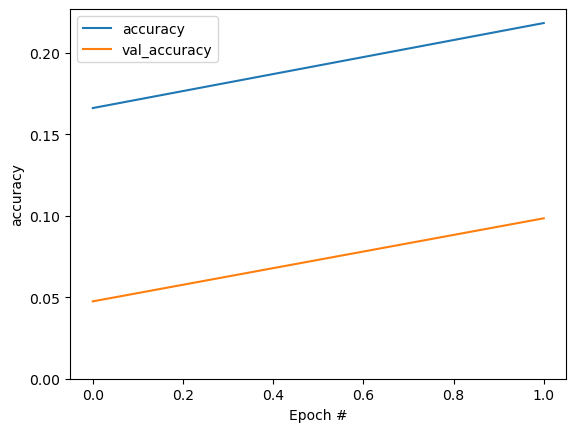

In [21]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.legend()

In [22]:
# result = model.translate(['¿Todavía está en casa?']) # Are you still home
# result[0].numpy().decode()

### Examples of translation

In [24]:
text_table = wandb.Table(columns=["source", "translate", "target", "temperature"])
n_samples = 10

for context_strings, target_strings in train_raw.take(1):
    for temp in np.arange(0.1, 0.7, 0.1):
        translate_strings = model.translate(context_strings, temperature=temp)

        encoded_strings = [x.numpy() for x in
                           [context_strings, translate_strings, target_strings]]
        print("Temperature is", np.round(temp, 2))
        for i in range(min(len(context_strings), n_samples)):
            for t in encoded_strings:
                print(t[i].decode())
            print()
            text_table.add_data(*[t[i].decode() for t in encoded_strings], temp)

wandb.log({"training_samples" : text_table})

Temperature is 0.1
Ve.
i the [UNK] of the [UNK] of the [UNK] of the [UNK] of the [UNK]        
Go.

Vaya.
i have the [UNK] of the [UNK] of the [UNK] of a [UNK] of the [UNK]       
Go.

Váyase.
tom was [UNK] to the [UNK] of the [UNK] of the [UNK] of the [UNK]        
Go.

Hola.
i the [UNK] [UNK] [UNK] to the [UNK] of the [UNK] of the [UNK]         
Hi.

¡Corre!
i the [UNK] [UNK] of the [UNK] [UNK] of the [UNK] of the [UNK] of the [UNK]      
Run!

¡Corran!
tom [UNK] the [UNK] [UNK] of the [UNK] of [UNK] to the [UNK] of the [UNK]       
Run!

¡Corra!
i the [UNK] [UNK] of the [UNK] of the [UNK] of the [UNK] of the [UNK]       
Run!

¡Corred!
tom was [UNK] to the [UNK] [UNK] of the [UNK] of the [UNK] of the [UNK]       
Run!

Corra.
i the [UNK] [UNK] [UNK] to the [UNK] [UNK] of the [UNK] of the [UNK]        
Run.

¡Órale!
tom [UNK] the [UNK] [UNK] of the [UNK] of the [UNK] of the [UNK]         
Wow!

Temperature is 0.2
Ve.
tom was [UNK] to the [UNK] of the [UNK] of the [UNK] of the [UNK]  

In [25]:
wandb.finish()

epoch/epoch,▁█
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/masked_acc,▁█
epoch/val_loss,▁█
epoch/val_masked_acc,▁█
epoch/epoch,1
epoch/learning_rate,0.001
epoch/loss,4.78694
epoch/masked_acc,0.21845
epoch/val_loss,5.66453
